In [1]:
import glob
from os import getcwd
import os
import pickle 
import pandas as pd
import numpy as np
import datetime
import random
import matplotlib.pyplot as plt

In [2]:
import random
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score , mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


In [3]:
def summaryGridresult(grid_result, tablename, printrow=6):
   print(tablename)
   print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
   res_tab = pd.DataFrame(grid_result.cv_results_).sort_values(by=['mean_test_score'], ascending=False)
   res_tab = res_tab[['params','mean_train_score','std_test_score','mean_test_score','std_test_score']]
   return res_tab[:printrow]

In [4]:
# precision
def get_pre(true, pred,threshold = 0.1): # the difference is not bigger than 3
    TP = 0
    for i in range(len(true)):
        if true[i]== 0:
            if abs(true[i]-pred[i]) <= 3:
                TP +=1 
        else:
            if abs(true[i]-pred[i])/true[i] <= threshold:
                TP +=1
    return TP/len(true)

def getmetrics(true, pred):
    r2 = r2_score(true, pred)
    mae = mean_absolute_error(true, pred)
    mse = mean_squared_error(true, pred)
    return mae, r2, mse

In [5]:
# Plot prediction
%matplotlib inline
def plotprediction(true, pred, modelname):
    pred_table = pd.DataFrame({'preds': pred}, index = true.index)
    prediction_table = true.join(pred_table)
    prediction_table = prediction_table.rename(columns = {'sales': 'true'})
    
    fig, ax = plt.subplots(figsize=(20,5))
    ax.plot(prediction_table['true'], label='Truth')
    ax.plot(prediction_table['preds'], label='Prediction')
    ax.set_title('Comparing prediction from {}'.format(modelname), fontsize=20)
    ax.set_xlabel('Time', fontsize=16)
    ax.set_ylabel('Sales', fontsize=16)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(8)
    leg = ax.legend(fontsize = 18)

In [6]:
# set seed
seed = 12345
#Storing model outcome:

all_outcome = {}

### Baseline Linear model: OLS

In [7]:
# get working directory
path = os.path.dirname(getcwd())
os.chdir(path)
with open("data/full_features/full-feature-tf/traindt.pkl", 'rb') as f:
   xtrain, ytrain =  pickle.load(file = f)
with open("data/full_features/full-feature-tf/testdt.pkl", 'rb') as f:
   xtest, ytest =  pickle.load(file = f)
with open("data/full_features/testdt_not_tf.pkl", 'rb') as f:
   _, ytest_df =  pickle.load(file = f)

In [8]:
random.seed(seed)
ols = LinearRegression()
ols_grid_pams = {'fit_intercept': [True, False]}
ols_grid_mod = GridSearchCV(ols, ols_grid_pams
                       , cv = 4, scoring = 'r2', 
                       return_train_score = True, 
                       n_jobs=-1)
grid_ols_res = ols_grid_mod.fit(xtrain, np.ravel(ytrain, 'C'))

In [9]:
summaryGridresult(grid_ols_res, 'Best results for simple linear model')

Best results for simple linear model
Best: 0.570555 using {'fit_intercept': True}


,params,mean_train_score,std_test_score,mean_test_score,std_test_score
0,{'fit_intercept': True},0.815890,0.086806,0.570555,0.086806
1,{'fit_intercept': False},0.257451,2.206082,-4.764874,2.206082


In [10]:
random.seed(seed)
ols_preds = ols_grid_mod.predict(xtest)

OLStest_out = {'mae': getmetrics(ytest, ols_preds)[0], 
               'r2':getmetrics(ytest, ols_preds)[1],
               'mse':getmetrics(ytest,ols_preds)[2], 
               'precision 10%': get_pre(ytest, ols_preds), 
               'precision 20%': get_pre(ytest, ols_preds, 0.2),
               'precision 30%': get_pre(ytest, ols_preds, 0.3)}

all_outcome['OLS'] = OLStest_out

OLStest_out

{'mae': 8.487313442977326,
 'r2': 0.7645285987479887,
 'mse': 129.04883261886746,
 'precision 10%': 0.33653846153846156,
 'precision 20%': 0.5192307692307693,
 'precision 30%': 0.6153846153846154}

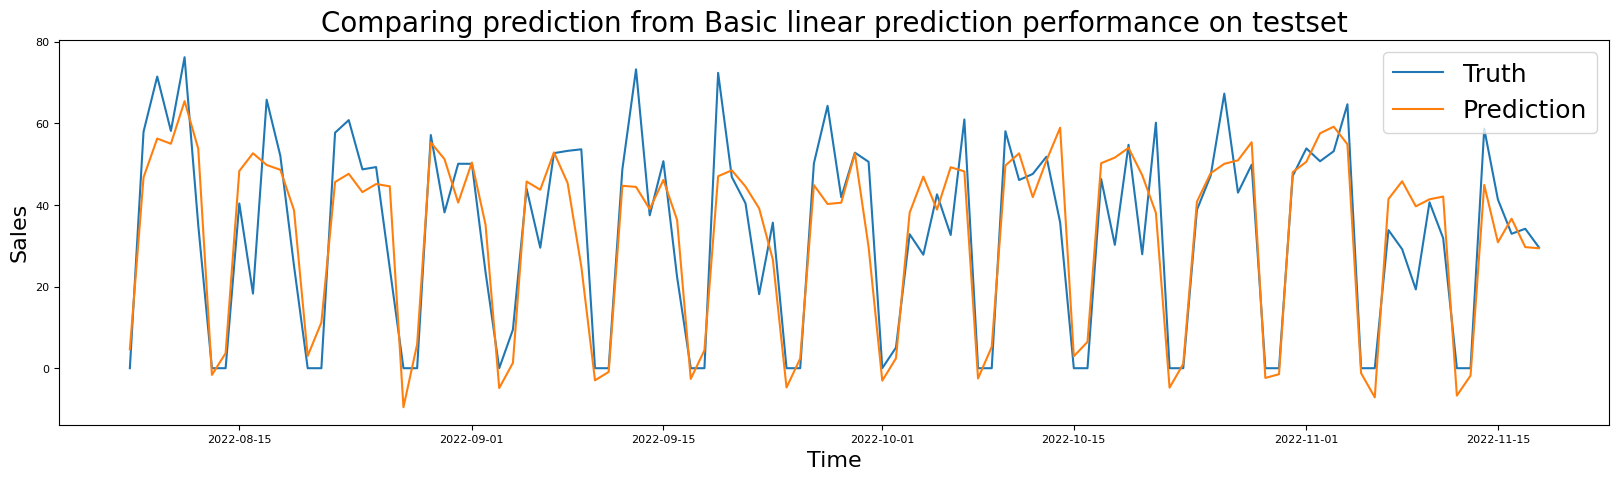

In [11]:
plotprediction(ytest_df, ols_preds.flatten(), 
               'Basic linear prediction performance on testset')

### Lasso Linear

In [12]:
# Grid search
lasso = Lasso(random_state=0, max_iter=50000)
ls_grid_pams = {'alpha':[0.01, 0.1, 1, 10, 100],
                 'selection':['cyclic','random']}

ls_grid_mod = GridSearchCV(lasso, ls_grid_pams
                       , cv = 4, scoring = 'r2',
                       return_train_score=True, 
                       n_jobs=-1)
ls_grid_res=ls_grid_mod.fit(xtrain, ytrain)

In [13]:
summaryGridresult(ls_grid_res, 'Best result for Lasso model')

Best result for Lasso model
Best: 0.658331 using {'alpha': 0.1, 'selection': 'random'}


,params,mean_train_score,std_test_score,mean_test_score,std_test_score
3,"{'alpha': 0.1, 'selection': 'random'}",0.765693,0.042493,0.658331,0.042493
2,"{'alpha': 0.1, 'selection': 'cyclic'}",0.765749,0.042532,0.658231,0.042532
5,"{'alpha': 1, 'selection': 'random'}",0.717397,0.054300,0.643784,0.054300
4,"{'alpha': 1, 'selection': 'cyclic'}",0.717391,0.054328,0.643750,0.054328
0,"{'alpha': 0.01, 'selection': 'cyclic'}",0.798067,0.038747,0.627317,0.038747
1,"{'alpha': 0.01, 'selection': 'random'}",0.798053,0.038805,0.627185,0.038805


In [14]:
random.seed(seed)
ls_preds = ls_grid_mod.predict(xtest)

LSTest_out = {'mae': getmetrics(ytest, ls_preds)[0], 
               'r2':getmetrics(ytest, ls_preds)[1], 
               'mse':getmetrics(ytest,ls_preds)[2], 
               'precision 10%': get_pre(ytest, ls_preds), 
               'precision 20%': get_pre(ytest, ls_preds, 0.2),
               'precision 30%': get_pre(ytest, ls_preds, 0.3)}
all_outcome['lasso'] = LSTest_out
LSTest_out


{'mae': 8.629388971952633,
 'r2': 0.7450177008447783,
 'mse': 139.74167508027745,
 'precision 10%': 0.36538461538461536,
 'precision 20%': 0.5384615384615384,
 'precision 30%': 0.6346153846153846}

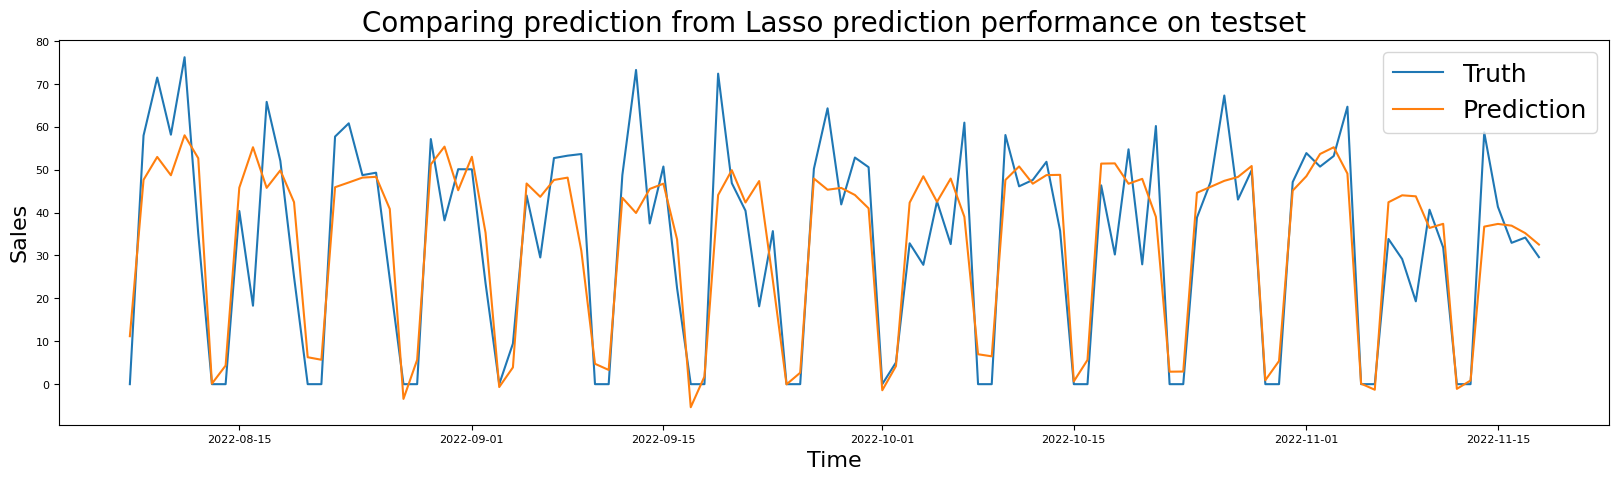

In [15]:
plotprediction(ytest_df, ls_preds, 
               'Lasso prediction performance on testset')

# Ridge Linear

In [16]:
# Grid search
random.seed(seed)
ridge = Ridge(random_state=0, max_iter=50000)
rid_grid_pams = {'alpha':[0.01, 0.1, 1, 10, 100],
                 'solver':['svd', 'cholesky', 'sparse_cg', 'lsqr', 'sag']}
rid_grid_mod = GridSearchCV(ridge, rid_grid_pams,
                           cv = 4, scoring = 'r2',
                           return_train_score=True)
rid_grid_res = rid_grid_mod.fit(xtrain, ytrain)

In [17]:
summaryGridresult(rid_grid_res, 'Best result for Ridge Linear model')

Best result for Ridge Linear model
Best: 0.669515 using {'alpha': 100, 'solver': 'lsqr'}


,params,mean_train_score,std_test_score,mean_test_score,std_test_score
23,"{'alpha': 100, 'solver': 'lsqr'}",0.747432,0.025367,0.669515,0.025367
22,"{'alpha': 100, 'solver': 'sparse_cg'}",0.747639,0.024644,0.669127,0.024644
21,"{'alpha': 100, 'solver': 'cholesky'}",0.747713,0.024636,0.669025,0.024636
20,"{'alpha': 100, 'solver': 'svd'}",0.747713,0.024636,0.669025,0.024636
24,"{'alpha': 100, 'solver': 'sag'}",0.747573,0.024647,0.668967,0.024647
19,"{'alpha': 10, 'solver': 'sag'}",0.777271,0.026872,0.658882,0.026872


In [18]:
random.seed(seed)
rid_preds = rid_grid_mod.predict(xtest)

RidTest_out = {'mae': getmetrics(ytest, rid_preds)[0], 
               'r2':getmetrics(ytest, rid_preds)[1], 
               'mse':getmetrics(ytest,rid_preds)[2], 
               'precision 10%': get_pre(ytest, rid_preds), 
               'precision 20%': get_pre(ytest, rid_preds, 0.2),
               'precision 30%': get_pre(ytest, rid_preds, 0.3)}
all_outcome['Ridge']=RidTest_out
RidTest_out


{'mae': 8.924375604006672,
 'r2': 0.7315980716110333,
 'mse': 147.0962305701792,
 'precision 10%': 0.38461538461538464,
 'precision 20%': 0.5096153846153846,
 'precision 30%': 0.625}

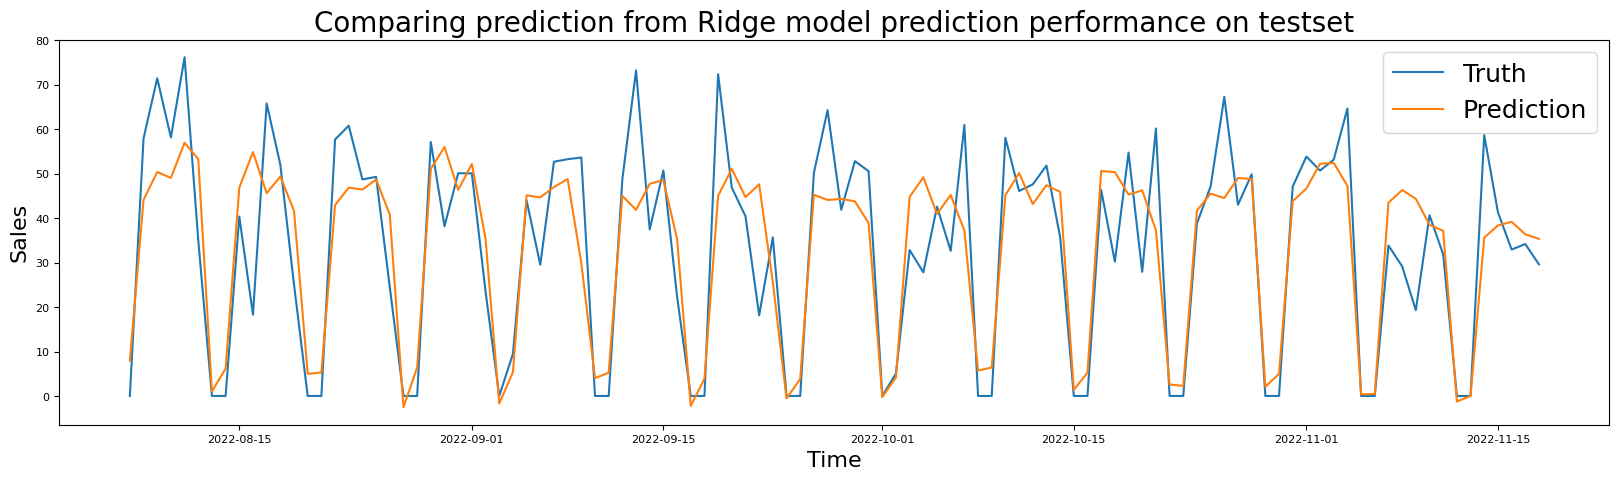

In [19]:
plotprediction(ytest_df, rid_preds.flatten(), 
               'Ridge model prediction performance on testset')

# KNN Knearest neighbors

In [20]:
# Grid search
random.seed(seed)
knn = KNeighborsRegressor()
knn_grid_pams = {'n_neighbors' : [5,10,15,20],
               'weights':['uniform', 'distance']}
knn_grid_mod = GridSearchCV(knn, knn_grid_pams
                       , cv = 4, scoring = 'r2',
                       return_train_score=True)

knn_grid_res = knn_grid_mod.fit(xtrain, ytrain)

In [21]:
summaryGridresult(knn_grid_res, 'Best results for KNN model')

Best results for KNN model
Best: 0.540297 using {'n_neighbors': 10, 'weights': 'distance'}


,params,mean_train_score,std_test_score,mean_test_score,std_test_score
3,"{'n_neighbors': 10, 'weights': 'distance'}",1.000000,0.055311,0.540297,0.055311
2,"{'n_neighbors': 10, 'weights': 'uniform'}",0.720584,0.054552,0.536969,0.054552
5,"{'n_neighbors': 15, 'weights': 'distance'}",1.000000,0.042839,0.527274,0.042839
7,"{'n_neighbors': 20, 'weights': 'distance'}",1.000000,0.052501,0.517894,0.052501
4,"{'n_neighbors': 15, 'weights': 'uniform'}",0.697082,0.045600,0.517673,0.045600
6,"{'n_neighbors': 20, 'weights': 'uniform'}",0.670723,0.056669,0.505878,0.056669


In [22]:
knn_preds = knn_grid_mod.predict(xtest)

knn_out = {'mae': getmetrics(ytest, knn_preds)[0], 
               'r2':getmetrics(ytest, knn_preds)[1], 
               'mse':getmetrics(ytest,knn_preds)[2], 
               'precision 10%': get_pre(ytest, knn_preds), 
               'precision 20%': get_pre(ytest, knn_preds, 0.2),
               'precision 30%': get_pre(ytest, knn_preds, 0.3)}
all_outcome['KNN10']=knn_out

knn_out

{'mae': 8.453692313535443,
 'r2': 0.7275343999852157,
 'mse': 149.3233039076199,
 'precision 10%': 0.46153846153846156,
 'precision 20%': 0.5961538461538461,
 'precision 30%': 0.75}

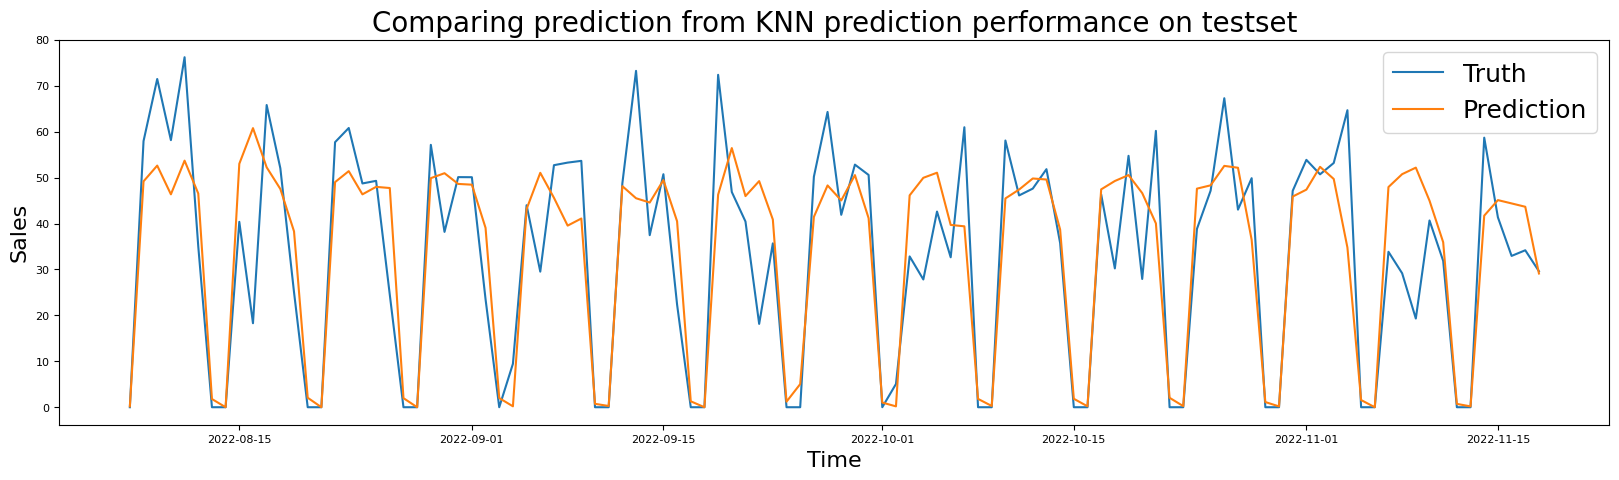

In [23]:
plotprediction(ytest_df, knn_preds.flatten(), 
               'KNN prediction performance on testset')

In [24]:
o_trs = {'mse':[], 'mae':[], 'r2':[], 'precision 10%':[], 'precision 20%':[],'precision 30%':[],}
index = all_outcome.keys()
i =  0
for mod in index:
    for m in ['mse', 'mae', 'r2', 'precision 10%', 'precision 20%', 'precision 30%']:
        o_trs[m].append(all_outcome[mod][m])
    
pd.DataFrame(data=o_trs, index=index)

,mse,mae,r2,precision 10%,precision 20%,precision 30%
OLS,129.048833,8.487313,0.764529,0.336538,0.519231,0.615385
lasso,139.741675,8.629389,0.745018,0.365385,0.538462,0.634615
Ridge,147.096231,8.924376,0.731598,0.384615,0.509615,0.625000
KNN10,149.323304,8.453692,0.727534,0.461538,0.596154,0.750000
